# Udacity Data Scientist Nanodegree Program - Project 1
---
This repository is part of the learning objectives of the [nanodegree in data science](https://www.udacity.com/course/data-scientist-nanodegree--nd025) provided by Udacity.

## Table of Contents

- [Project Description](project-description)

- [Dataset](#dataset)

- [Outro](#outro)

<a id="project-description"><a/>
## Project Description

In this project, I was responsible for finding a public dataset, coming up with some questions and searching for answers using the chosen data. As part of the project, I wrote a blog post with my insights and some additional information. 

To execute this project, I choose the [New York City Open Restaurant database](https://data.cityofnewyork.us/Transportation/Open-Restaurant-Applications/pitm-atqc) that contains information about the restaurants "seeking authorization to re-open under Phase Two of the State’s New York Forward Plan, and place outdoor seating in front of their business on the sidewalk and/or roadway". 
    
More details about this project can be found in the README of the repository containing this notebook.
    
My analysis are described in this [**medium blog post**](https://jfo-cruz.medium.com/this-is-where-you-can-enjoy-the-outdoor-dining-in-new-york-city-during-the-pandemic-7c06124c2d0d). 

---

In [1]:
# Import packages
import os
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import folium
from folium.plugins import MarkerCluster
import seaborn as sns

# Set plot configurations
cmap = plt.cm.get_cmap('Accent')
rc = {"axes.spines.left" : True,
      "axes.spines.right" : False,
      "axes.spines.bottom" : True,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : True}
plt.rcParams.update(rc)

<a id="dataset"><a/>
## The Dataset - [__Open Restaurant Applications__](https://data.cityofnewyork.us/Transportation/Open-Restaurant-Applications/pitm-atqc)

The dataset consists of 35 columns with information regarding the business nature of the establishment, location, type of outdoor dining requested, etc. For my analysis, I choose a subset of the columns containing the most relevant information for the questions I asked.

In [2]:
data = pd.read_csv(
    r'dataset/Open_Restaurant_Applications.csv',
    parse_dates=['Time of Submission'],  # Convert dates into datetime format
)

# get a quick look at the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12141 entries, 0 to 12140
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   objectid                                  12141 non-null  int64         
 1   globalid                                  12141 non-null  object        
 2   Seating Interest (Sidewalk/Roadway/Both)  12141 non-null  object        
 3   Restaurant Name                           12141 non-null  object        
 4   Legal Business Name                       12140 non-null  object        
 5   Doing Business As (DBA)                   12131 non-null  object        
 6   Building Number                           12141 non-null  object        
 7   Street                                    12141 non-null  object        
 8   Borough                                   12141 non-null  object        
 9   Postcode                    

In [3]:
# Drop data columns that are not necessary.
data.drop(columns=['Legal Business Name',
                   'Building Number',
                   'Doing Business As (DBA)',
                   'globalid',
                   'Food Service Establishment Permit #',
                   'Business Address',
                   'Sidewalk Dimensions (Length)',
                   'Sidewalk Dimensions (Width)',
                   'Roadway Dimensions (Length)',
                   'Roadway Dimensions (Width)',
                   'SLA Serial Number',
                   'healthCompliance_terms',
                   'Community Board',
                   'Council District',
                   'Census Tract',
                   'BBL',
                   'BIN',   
                   ],
           inplace=True,
         )

## The Analysis


### Q1. Which borough and neighborhoods contains the highest amount of restaurants with outdoor dining available?
---

In [4]:
# get the number of total number of outdoor dinning requests in each borough
r_borough = data.loc[:, 'Borough']\
                .value_counts()\
                .apply(lambda x: round(x, 2))\
                .reset_index()

# Create a new column with normalized values as percentage
r_borough['Borough_%'] = (r_borough['Borough'] / r_borough['Borough'].sum() * 100
                            ).apply(lambda x: round(x))

display(r_borough)

,index,Borough,Borough_%
0,Manhattan,5868,48
1,Brooklyn,2952,24
2,Queens,2463,20
3,Bronx,666,5
4,Staten Island,192,2


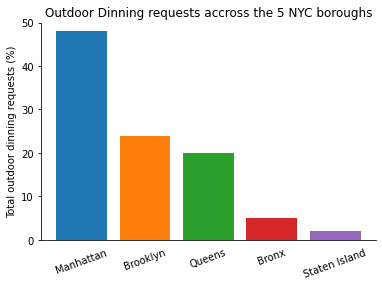

In [5]:
# plot the information above
fig, ax = plt.subplots()

ax.bar(
    r_borough['index'],
    r_borough['Borough_%'],
    color=[f'C{i}' for i in range(5)]
)

ax.set(
    ylabel='Total outdoor dinning requests (%)',
    title='Outdoor Dinning requests accross the 5 NYC boroughs',
    ylim=(0, 50),
)
ax.tick_params('x', rotation=20)

plt.show()

It seems that Manhattan accounts for around 50 % of all the requests, even not being the biggest borough both in terms of [area](https://en.wikipedia.org/wiki/Boroughs_of_New_York_City) and [population](https://www.census.gov/quickfacts/fact/table/newyorkcitynewyork,bronxcountybronxboroughnewyork,kingscountybrooklynboroughnewyork,newyorkcountymanhattanboroughnewyork,queenscountyqueensboroughnewyork,richmondcountystatenislandboroughnewyork/PST045219). 
What about the number of successful requests?

In [6]:
# Get the restaurants with approved outdoor dinning (either sidewalk OR roadwalk)
outdoor_approved = (data.loc[:, 'Approved for Sidewalk Seating'].isin(['yes'])\
                    | data.loc[:, 'Approved for Roadway Seating'].isin(['yes']))

r_borough_approved = data[outdoor_approved].loc[:, 'Borough'].value_counts(normalize=True) * 100

r_borough_approved

Manhattan        48.098149
Brooklyn         24.257089
Queens           20.487349
Bronx             5.561216
Staten Island     1.596196
Name: Borough, dtype: float64

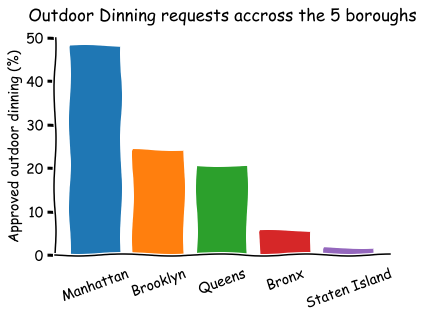

In [7]:
# plot the data above with the style xkcd > https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xkcd.html
with plt.xkcd():
    fig, ax = plt.subplots()

    ax.bar(
        r_borough_approved.index,
        r_borough_approved,
        color=[f'C{i}' for i in range(5)]
    )

    ax.set(
        ylabel='Approved outdoor dinning (%)',
        ylim=(0, 50),
    )
    ax.set_title(
        label='Outdoor Dinning requests accross the 5 boroughs',
        y=1.05
    )
    ax.tick_params('x', rotation=20)


As we can observe, it did not change much. In fact, almost all the requests were accepted:

In [8]:
# Split the restaurants whose requests were accepted and denied. 
outdoor_approved = data.loc[:, 'Approved for Sidewalk Seating'].isin(['yes'])\
                   | data.loc[:, 'Approved for Roadway Seating'].isin(['yes'])

# Subset the data in approved and rejected
r_borough_approved = data[outdoor_approved].loc[:, 'Borough'].value_counts() / data.shape[0] * 100
r_borough_rejected = data[~outdoor_approved].loc[:, 'Borough'].value_counts() / data.shape[0] * 100

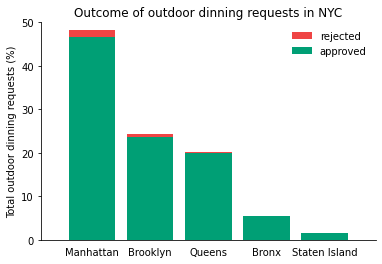

In [9]:
fig, ax = plt.subplots()

ax.bar(
    r_borough_rejected.index,
    r_borough_rejected,
    bottom=r_borough_approved,
    label='rejected',
    color='#EF4444'
)

ax.bar(
    r_borough_approved.index,
    r_borough_approved,
    label='approved',
    color='#009F75'
)


ax.set(
    ylabel='Total outdoor dinning requests (%)',
    title='Outcome of outdoor dinning requests in NYC',
    ylim=(0, 50),
    
)

ax.legend(frameon=False)
ax.margins(0.1)
fig.patch.set_facecolor('white')

In [10]:
# get df with requests denied and normalization to total requests in that borough
data_denied = pd.concat([data[~outdoor_approved].loc[:, 'Borough'].value_counts(),
                         r_borough_rejected],
                        axis=1,
                        )
# rename columns
data_denied.columns = ['requests_rejected', 'requests_rejected_norm']

data_denied.head()

,requests_rejected,requests_rejected_norm
Manhattan,203,1.672020
Brooklyn,95,0.782473
Queens,50,0.411828
Bronx,11,0.090602
Staten Island,4,0.032946


Another way of visualizing the the distribution of restaurants across borough is by plotting a waffle chart. While in other languages this process is pretty straightforward, in python it requires bending matplotlib to our will!

In [11]:
total_approved = data[outdoor_approved].loc[:, 'Borough'].shape[0]

nyc_outdoor_dinning = (data[outdoor_approved].loc[:, 'Borough'].value_counts() / total_approved) * 100
total_nyc_abs_values = data[outdoor_approved].loc[:, 'Borough'].value_counts().sum()

In [12]:
# Set the width and height of the chart, respectively
width = 20
height = 5
total_num_tiles = width * height

# Calculate the number of tiles per borough
proportion_tiles = [
    round(total_num_tiles * proportion) for proportion in (nyc_outdoor_dinning.to_numpy() / 100)
]

final_array = np.zeros((height, width))

borough = 0
borough_tile = 0

# populate the empy matrix with an integer corresponding to the borough
for row in range(0, width):
    
    for col in range(0, height):
        
        # assign a "tile"
        final_array[col, row] = borough
        borough_tile += 1
        
        # if there are no more tiles, move to the next borough
        if borough_tile == proportion_tiles[borough]:
            borough += 1
            borough_tile = 0

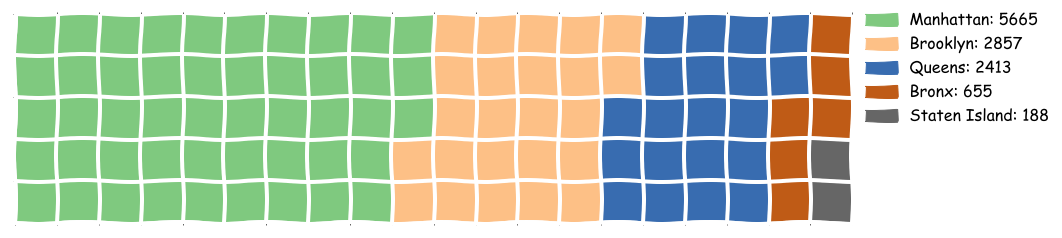

In [13]:
with plt.xkcd():
    
    # instantiate a new figure object
    fig, ax = plt.subplots(figsize=(15, 15))

    colormap = plt.cm.Accent
    cmap = plt.get_cmap('Accent')

    # use matshow to display the waffle chart
    ax.matshow(
        final_array,
        cmap=colormap,
    )

    ax.set_yticks(
        ticks=np.arange(-.5, (height), 1),
        minor=True,
    );
    ax.set_xticks(
        ticks=np.arange(-.5, (width), 1),
        minor=True,
    );
    
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1.5)
    ax.set(xticks=[], yticks=[]);


    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(nyc_outdoor_dinning.to_numpy())
    total_values = values_cumsum[-1] # Access the last element

    # create legend
    legend_handles = []
    odd_colors_cmap = [0, 2, 4, 6, 8]
    for i, category in enumerate(nyc_outdoor_dinning.index):
        label_str = f'{category}: {(nyc_outdoor_dinning.to_numpy()[i]*total_nyc_abs_values)/100:0.0f}'
        color_val = cmap(odd_colors_cmap[i])
        legend_handles.append(mpatches.Patch(color=color_val,
                                             label=label_str),
                             )

    # https://matplotlib.org/stable/tutorials/colors/colormaps.html

    # add legend to chart
    plt.legend(handles=legend_handles,
               loc='lower center', 
               ncol=1,
               bbox_to_anchor=(0., 0.4, 2.25, .1),
               frameon=False,
               fontsize=16
              )
    
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')

    # Add white background
    fig.patch.set_facecolor('white')

### Q2. Where is located the highest number of restaurants in close proximity to a landmark building or location?
---

Restaurants with approved outdoor dining are mostly common in Manhattan. I wondered whether they are evenly spread across the different neighborhoods or clustered in specific areas. Let's find out!

In [14]:
# Subset the data to get manhattan data
manh_data = data[data['Borough'].isin(['Manhattan'])].reset_index(drop=True)

In [15]:
# Further subset the manhattan data to get the approved requests. 
outdoor_approved = manh_data.loc[:, 'Approved for Sidewalk Seating'].isin(['yes'])\
                   | manh_data.loc[:, 'Approved for Roadway Seating'].isin(['yes'])

manh_data = manh_data[outdoor_approved]

manh_data.head(2)

,objectid,Seating Interest (Sidewalk/Roadway/Both),Restaurant Name,Street,Borough,Postcode,Sidewalk Dimensions (Area),Roadway Dimensions (Area),Approved for Sidewalk Seating,Approved for Roadway Seating,Qualify Alcohol,SLA License Type,Landmark District or Building,landmarkDistrict_terms,Time of Submission,Latitude,Longitude,NTA
0,11834,sidewalk,KAIKAGETSU NYC,162 ORCHARD STREET,Manhattan,10002,80.0,NaN,yes,no,yes,OP,no,NaN,2021-02-03 14:18:00,40.721037,-73.988730,Chinatown
1,11835,roadway,"THE STANDARD, HIGH LINE",848 WASHINGTON STREET,Manhattan,10014,NaN,1600.0,no,yes,yes,HL,no,NaN,2021-02-04 14:12:00,40.740624,-74.007719,West Village


One powerful way to visualize the data (approved restaurants) in relation to the space (eg Manhattan city landscape) is by building [choropleth](https://en.wikipedia.org/wiki/Choropleth_map) map using [folium](https://python-visualization.github.io/folium/). 

New York City organizes the neighborhoods according to Neighborhood Tabulation Areas (NTA). Each of the neighborhoods can be composed of more than one commonly known area. More information about NTA can be found [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-nynta.page).

In [16]:
# Group data by number of restaurants per NTA
restaurants_per_NTA = manh_data.groupby(['NTA'])\
                               .count()['objectid']\
                               .reset_index()\
                               .rename({'NTA': 'NTAName', 'objectid': 'n_restaurants'}, axis=1)

# show the first 5 rows
restaurants_per_NTA.head()

,NTAName,n_restaurants
0,Battery Park City-Lower Manhattan,160
1,Bay Ridge,1
2,Central Harlem North-Polo Grounds,46
3,Central Harlem South,64
4,Chinatown,270


In [17]:
# load and clean the geojson with the areas of each NTA
nyc_geo = r'dataset/nyc_nta.json'
with open(nyc_geo) as file:
    nyc_nta = json.load(file)

# Extract manhattan NTAs
nyc_nta['features'] = [sub_feature for sub_feature in nyc_nta.get('features')
                       if sub_feature.get('properties').get('BoroName') == 'Manhattan']

In [18]:
# Instantiate NYC map
m = folium.Map(location=[40.7529078, -73.9941886],
               zoom_start=11,
               tiles='cartodbpositron'
              )

# Add the number of approved restaurants per NTA
folium.Choropleth(
    geo_data=nyc_nta,
    name="choropleth",
    data=restaurants_per_NTA,
    columns=["NTAName", "n_restaurants"],
    key_on="feature.properties.NTAName",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=2,
    legend_name="Number of Restaurants With Approved Outdoor Dinning",
    highlight=True,
).add_to(m)

# took some code from here: https://vverde.github.io/blob/interactivechoropleth.html

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

# Allow pop-up to appear when hovering with the mouse
NIL = folium.features.GeoJson(
    nyc_nta,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=["NTAName"],
        aliases=[''],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)
folium.LayerControl().add_to(m)

m

We can observe that the majority of the restaurants with outdoor dining are located South of Central Park. Which are the top 3 neighborhoods with the most outdoor dining available in Manhattan?

In [19]:
# count the number of individual restaurants in each NTA
nta_rest_counts = manh_data['NTA'].value_counts()


print('The top 3 NTA in manhattan are:')

for nta in nta_rest_counts.index[:5]:
    print(f'{nta} with {nta_rest_counts.loc[nta,]} restaurants')

proportion_top5 = nta_rest_counts[:5].sum() / nta_rest_counts.sum()
print(f'The top 5 NTA contain {proportion_top5* 100:0.02f}% of all {nta_rest_counts.index.size} areas!')

The top 3 NTA in manhattan are:
West Village with 580 restaurants
Midtown-Midtown South with 518 restaurants
East Village with 454 restaurants
SoHo-TriBeCa-Civic Center-Little Italy with 441 restaurants
Hudson Yards-Chelsea-Flatiron-Union Square with 406 restaurants
The top 5 NTA contain 47.96% of all 35 areas!


So we can observe that the location of the restaurants is highly clustered in some particular areas. Let's subset our search to the restaurants that are in proximity to [NYC landmark buildings or districts](https://nyclpc.maps.arcgis.com/apps/webappviewer/index.html?id=93a88691cace4067828b1eede432022b). Which restaurants are located in a landmark district or building?



First, let's have a look at the proportion of restaurants that are located in a landmark location in Manhattan.


In [20]:
# Group manhattan restaurants by the landmark feature
landmark_restaurants = manh_data.groupby(['Borough', 'Landmark District or Building'])['Borough']\
                                .count()\

display(landmark_restaurants)

Borough    Landmark District or Building
Manhattan  no                               4445
           yes                              1220
Name: Borough, dtype: int64

In [21]:
# normalize to the total number of restaurants
lmark_result = (landmark_restaurants / landmark_restaurants.sum())

manhattan_lmark_y = lmark_result[('Manhattan', 'yes')]

print(f'In Manhattan, there are {manhattan_lmark_y*100:0.02f}% of the restaurants are located in a landmark district or building.')

In Manhattan, there are 21.54% of the restaurants are located in a landmark district or building.


What is the NTA with the highest concentration?

In [22]:
# Group data
landmark_NTA = manh_data.groupby(['NTA', 'Landmark District or Building'])['objectid']\
                        .count()\
                        .sort_values(ascending=False)\
                        .reset_index()


landmark_NTA = landmark_NTA[landmark_NTA['Landmark District or Building'].isin(['yes'])]
landmark_NTA.rename(columns={'objectid': 'n_restaurants'}, inplace=True)

landmark_NTA.head(3)

,NTA,Landmark District or Building,n_restaurants
2,West Village,yes,376
9,SoHo-TriBeCa-Civic Center-Little Italy,yes,149
16,Hudson Yards-Chelsea-Flatiron-Union Square,yes,118


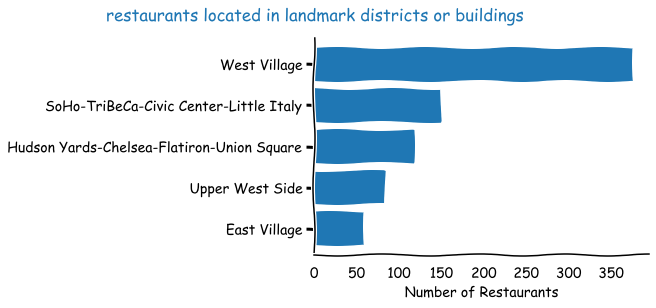

In [23]:
# Plot the results
with plt.xkcd():
    fig, ax = plt.subplots()

#     ax1 = ax.twiny()
    ax.barh(
        y=landmark_NTA['NTA'].head()[::-1],
        width=landmark_NTA['n_restaurants'].head()[::-1],

    )

    ax.set_xlabel('Number of Restaurants')
    ax.set_title('restaurants located in landmark districts or buildings', x=0, color='C0', y=1.05)
    

It seems that West Village contains the higher number of restaurants with outdoor dining around important landmark locations and it far exceeds the second in place composed by the historical neighborhoods of SoHo, Tribeca, Civic Center and Little Italy.

## Q3. What is the proportion of restaurants providing outdoor dining that offer alcoholic beverages in the neighborhood with the highest density of landmark locations?
---

The last aspect that I explored was the capacity of the restaurant that offers outdoor dining AND is located in a landmark building or area to serve alcohol.


In [24]:
# Subset dataset by landmark district of building in manhattan
cond = manh_data['Landmark District or Building'].isin(['yes'])
lmark_manh_data = manh_data[cond]

lmark_manh_data.head(2)

,objectid,Seating Interest (Sidewalk/Roadway/Both),Restaurant Name,Street,Borough,Postcode,Sidewalk Dimensions (Area),Roadway Dimensions (Area),Approved for Sidewalk Seating,Approved for Roadway Seating,Qualify Alcohol,SLA License Type,Landmark District or Building,landmarkDistrict_terms,Time of Submission,Latitude,Longitude,NTA
3,11836,both,NOI DUE INC,491 COLUMBUS AVENUE,Manhattan,10024,242.0,176.0,yes,yes,yes,OP,yes,yes,2021-02-04 16:24:00,40.784922,-73.973303,Upper West Side
7,11840,roadway,SHAKE SHACK,1333 BROADWAY,Manhattan,10018,NaN,392.0,no,yes,yes,RW,yes,yes,2021-02-06 19:24:00,40.750829,-73.987761,Midtown-Midtown South


In [25]:
# get the the restaurants that qualify for selling alchool 
qualify_alcohol = pd.concat(
    [lmark_manh_data['Qualify Alcohol'].value_counts(normalize=False),
     (lmark_manh_data['Qualify Alcohol'].value_counts(normalize=True) * 100)],
    axis=1,
).apply(lambda x: round(x, 2))

qualify_alcohol.columns = ['qualify_alcohol_raw', 'qualify_alcohol_%']

display(qualify_alcohol)

,qualify_alcohol_raw,qualify_alcohol_%
yes,981,80.41
no,239,19.59


In Manhattan over 80% of the restaurants offer alcohol. What about specifically in the West Village?

In [26]:
# get west village condition
NTA_lmark_top = landmark_NTA.iloc[0, 0]

# subset data to include only restaurants located in west village
lmark_manh_data_top_NTA = lmark_manh_data[lmark_manh_data['NTA'].isin([NTA_lmark_top])]

lmark_manh_data_top_NTA.head()

,objectid,Seating Interest (Sidewalk/Roadway/Both),Restaurant Name,Street,Borough,Postcode,Sidewalk Dimensions (Area),Roadway Dimensions (Area),Approved for Sidewalk Seating,Approved for Roadway Seating,Qualify Alcohol,SLA License Type,Landmark District or Building,landmarkDistrict_terms,Time of Submission,Latitude,Longitude,NTA
20,11849,sidewalk,THE COMMERCE INN,50 COMMERCE STREET,Manhattan,10014,850.0,NaN,yes,no,yes,OP,yes,yes,2021-02-15 08:45:00,40.731388,-74.005560,West Village
36,11857,both,Lena,10 MORTON STREET,Manhattan,10014,210.0,105.0,yes,yes,yes,RW,yes,yes,2021-02-17 10:14:00,40.731334,-74.003532,West Village
47,11861,both,ZERO BOND,670 BROADWAY,Manhattan,10012,960.0,960.0,yes,yes,yes,OP,yes,yes,2021-02-19 02:58:00,40.727299,-73.995183,West Village
52,11866,sidewalk,COCU ROTISSERIE,26 CARMINE STREET,Manhattan,10014,200.0,NaN,yes,no,yes,RW,yes,yes,2021-02-22 15:27:00,40.730208,-74.002811,West Village
56,11871,sidewalk,STUMPTOWN COFFEE ROASTERS,30 WEST 8 STREET,Manhattan,10011,1500.0,NaN,yes,no,no,NaN,yes,yes,2021-02-23 14:57:00,40.732750,-73.997546,West Village


In [27]:
proportion_west_village = lmark_manh_data_top_NTA.groupby(['NTA'])['Qualify Alcohol']\
                                                 .value_counts(normalize=True)\
                                                 .apply(lambda x: round(x, 2))

display(proportion_west_village)

NTA           Qualify Alcohol
West Village  yes                0.85
              no                 0.15
Name: Qualify Alcohol, dtype: float64

In West Village, the percentage of restaurants selling alcohol is higher by around 5% compared to the whole manhattan restaurants in landmark buildings/locations. Where are they located?

In [28]:
# subset the data to west village to create a new choropleth map
lmark_west_village = lmark_manh_data_top_NTA[lmark_manh_data_top_NTA.NTA.isin(['West Village'])]

lmark_west_village.groupby('Street')['objectid'].count().sort_values(ascending=False)[:5]

lmark_west_village.head(3)

,objectid,Seating Interest (Sidewalk/Roadway/Both),Restaurant Name,Street,Borough,Postcode,Sidewalk Dimensions (Area),Roadway Dimensions (Area),Approved for Sidewalk Seating,Approved for Roadway Seating,Qualify Alcohol,SLA License Type,Landmark District or Building,landmarkDistrict_terms,Time of Submission,Latitude,Longitude,NTA
20,11849,sidewalk,THE COMMERCE INN,50 COMMERCE STREET,Manhattan,10014,850.0,NaN,yes,no,yes,OP,yes,yes,2021-02-15 08:45:00,40.731388,-74.005560,West Village
36,11857,both,Lena,10 MORTON STREET,Manhattan,10014,210.0,105.0,yes,yes,yes,RW,yes,yes,2021-02-17 10:14:00,40.731334,-74.003532,West Village
47,11861,both,ZERO BOND,670 BROADWAY,Manhattan,10012,960.0,960.0,yes,yes,yes,OP,yes,yes,2021-02-19 02:58:00,40.727299,-73.995183,West Village


In [29]:
m = folium.Map(location=[40.73578, -74.00357],
               zoom_start=14.5,
               tiles='cartodbpositron'
              )

for restaurant in range(lmark_west_village.index.size):
    
    if lmark_west_village.iloc[restaurant, 10] == 'yes':
        color='darkblue'
        group = 'Offer Alchool: Yes'
        fg = folium.FeatureGroup(name=f'<span style="color: {color};">{group}</span>')
        m.add_child(fg)
        
        marker = folium.Marker(
            location=(lmark_west_village.Latitude.iloc[restaurant],
                      lmark_west_village.Longitude.iloc[restaurant]), 
            popup=lmark_west_village['Restaurant Name'].iloc[restaurant],
            icon=folium.map.Icon(color),
        ).add_to(m)
        
        
    else:
        color='darkred'
        group = 'Offer Alchool: No'
        fg = folium.FeatureGroup(name=f'<span style="color: {color};">{group}</span>')
        m.add_child(fg)
        
        marker = folium.Marker(
            location=(lmark_west_village.Latitude.iloc[restaurant],
                      lmark_west_village.Longitude.iloc[restaurant]), 
            popup=lmark_west_village['Restaurant Name'].iloc[restaurant],
            icon=folium.Icon(color, icon="info-sign")
        ).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

# Allow pop-up to appear when hovering with the mouse
NIL = folium.features.GeoJson(
    nyc_nta,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=["NTAName"],
        aliases=[''],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)
folium.LayerControl().add_to(m)

m

m    


The distribution of the restaurants in a landmark building or area are quite spread across West Village. To complete this part, we can have a look at the street with highest number of establishments:

In [30]:
lmark_west_village_top = lmark_west_village.groupby(['Street', 'Qualify Alcohol'])['objectid']\
                                            .count()\
                                            .sort_values(ascending=False)
print('The Streets in Westvillage that contain the higher amount of restaurants offering outdoor dinning,',
      'allowed to sell alcohol and located in landmark locations are:')
print(lmark_west_village_top[:3])

The Streets in Westvillage that contain the higher amount of restaurants offering outdoor dinning, allowed to sell alcohol and located in landmark locations are:
Street            Qualify Alcohol
Greenwich Avenue  yes                16
Hudson Street     yes                16
West 4th Street   yes                12
Name: objectid, dtype: int64


<a id="outro"><a/> 

## Outro
---    
    
Thank you for reading my work and I hope it was informative. If you find a mistake or if you have suggestions, please let me know. Enjoy!

---
_**Disclaimer:**_
_The data used is part of the open datasets from new york city and this post was part of the learning objectives of the degree in Data Science provided by Udacity. The author is not affiliated with any of the entities mentioned nor received any kind of compensation. The author assumes no responsibility or liability for any errors or omissions in the content of this post. The information contained in this site is provided on an "as is" basis with no guarantees of completeness, accuracy, usefulness or timeliness._


2021 - Jose Oliveira da Cruz